# Cross validation using Research Module

## Roadmap

1. Introduction to Research Module
    * Basic example
        * 1 pipeline with fixed parameters
             * creating research
             * running several repetitions of an experiment
             * viewing research results
             * saving and loading research
    * Runnung experiments with different parameters aka grid
        * 1 pipeline with variable parameters
             * creating and viewing grids
             * viewing filtered research results
             
             
2. Complex Execution Strategies with Research Module
    * Reducing extra dataset loads
        * 1 pipeline with root and branch + grid
    * More complex execution strategies
        * 2 pipelines, train & test + function + root&branch + grid
            * adding test pipeline
            * defining results recording frequency aka execute='%n'
            * adding functions
    * Performance
        * execution tasks managing
        
3. Cross-validation  (**You are here**)

4. Combining it all together
    * Super complex Research

## Cross-validation

In [1]:
import sys
sys.path.append('../../..')

import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

import tensorflow as tf

In [11]:
BATCH_SIZE=64
ITERATIONS=1000
TEST_EXECUTE_FREQ='%' + str(ITERATIONS//100)

One can easyly perform cross-validation with Research

Firstly we will define a dataset: we will use train subset of MNIST

In [3]:
mnist_train = MNIST().train

Next, we define our train and test pipelines. When performing cross-validation, Research will automatically split the dataset given and feed the folds to pipelines, so we will rather define pipeline templates that will wait for a dataset to work with. In contrast with previous tutorials we are adding `run` method to pipeline templates, not dataset pipelines.

In [4]:
model_config={
    'session/config': tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.24)),
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('train_loss', mode='w'))
).run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [5]:
test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                               fetches='predictions',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics'))
).run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)

In [6]:
def get_accuracy(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate('accuracy')

grid = Option('layout', ['cna', 'can'])

We are now defining our Research object. To use cross-validation we should pass `dataset` and `part` parameters to `add_pipeline` methods. We don't pass any dataset to `root` explicitely scince this is now Research that cares for data.

Next, we call `run` with `n_splits` parameter that defines the number of cv folds. We can also pass `shuffle` to specify whether to shuffle the dataset before splitting. `shuffle` can be bool, int, `numpy.random.RandomState` or callable, its default value is *False* which means no shuffling.

In [12]:
research = (Research()
            .add_pipeline(train_template, dataset=mnist_train, part='train', variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, dataset=mnist_train, part='test', name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .add_function(get_accuracy, returns='accuracy', name='test_accuracy_fn', 
                          execute=TEST_EXECUTE_FREQ, 
                          pipeline='test_ppl')
            .add_grid(grid))

research.run(n_iters=ITERATIONS,
             n_splits=3, shuffle=True,
             #workers=2, gpu=[0], 
             name='my_research', bar=True)

Research my_research_13 is starting...
Distributor has 6 jobs with 1000 iterations. Totally: 6000


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [44:27<00:00,  2.25it/s]


We can now load results, specifying which folds to get if needed

In [13]:
results = research.load_results(folds=0)
results.sample(10)

,repetition,name,train_loss,accuracy,iteration,layout,cv_split
191,0,train_ppl,0.191151,NaN,191,cna,0
834,0,train_ppl,0.106286,NaN,834,cna,0
529,0,train_ppl,0.219475,NaN,529,can,0
291,0,train_ppl,0.099053,NaN,291,cna,0
714,0,train_ppl,0.118109,NaN,714,can,0
30,0,test_accuracy_fn,NaN,1.0000,309,cna,0
63,0,test_accuracy_fn,NaN,0.9375,639,can,0
418,0,train_ppl,0.014946,NaN,418,can,0
306,0,train_ppl,0.156797,NaN,306,cna,0
591,0,train_ppl,0.036260,NaN,591,can,0


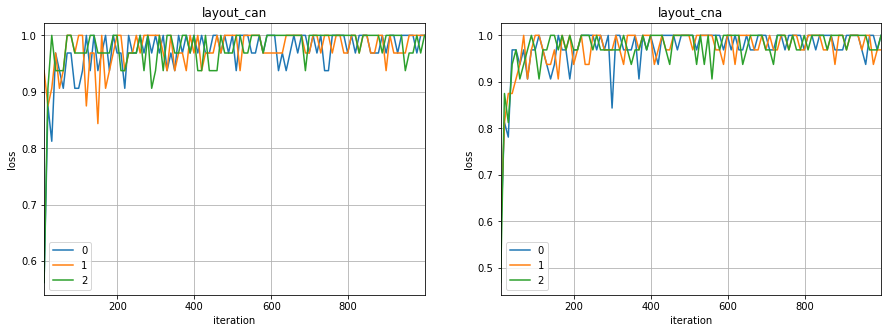

In [14]:
from matplotlib import pyplot as plt
test_results = research.load_results(names= 'test_accuracy_fn', use_alias=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, (config, df) in enumerate(test_results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='cv_split', values='accuracy').plot(ax=ax[y])
    ax[y].set_title(config)
    ax[y].set_xlabel('iteration')
    ax[y].set_ylabel('loss')
    ax[y].grid(True)
    ax[y].legend()

## Check working

We can still use branch-root division to preprocess the data

```python
augmentation_pipeline = Pipeline().salt(p=0.5)

research = (Research()
            .add_pipeline(root=augmentation_pipeline, branch=train_template, 
                          dataset=mnist_train, part='train', 
                          variables='train_loss', name='train_ppl')
#             .add_pipeline(test_template, 
#                           dataset=mnist_train, part='test', name='test_ppl',
#                          execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
#             .add_function(get_accuracy, returns='accuracy', name='test_accuracy_fn', 
#                           execute=TEST_EXECUTE_FREQ, 
#                           pipeline='test_ppl')
            .add_grid(grid))

research.run(n_iters=ITERATIONS,
             n_splits=3, shuffle=True,
             workers=2, branches=2, gpu=[0], 
             name='my_research', bar=True)
```

`research.load_results()`